In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt  
class TrafficEnvironment:
    def __init__(self, cycle_time=60, flow_rate=1):  
        self.cycle_time = cycle_time
        self.yellow_time = 5 
        self.flow_rate = flow_rate
        self.reset()
    
    def reset(self):
        self.ns_queue = 0
        self.ew_queue = 0
        self.time = 0
    
    def discretize_queue(self, queue_len):
        if queue_len <= 5: return 0 
        elif queue_len <= 10: return 1 
        else: return 2  
    
    def step(self, green_ns):
        
        arrivals_ns = random.randint(0, 5)
        arrivals_ew = random.randint(0, 5)

        green_ew = self.cycle_time - green_ns - 2 * self.yellow_time
        
        if green_ew < 0: green_ew = 0
        if green_ns + green_ew + 2 * self.yellow_time > self.cycle_time:
            green_ns = self.cycle_time // 2 - self.yellow_time
        
        throughput_ns = min(self.ns_queue + arrivals_ns, int(green_ns * self.flow_rate))
        throughput_ew = min(self.ew_queue + arrivals_ew, int(green_ew * self.flow_rate))
        
        # Update queues
        self.ns_queue = self.ns_queue + arrivals_ns - throughput_ns
        self.ew_queue = self.ew_queue + arrivals_ew - throughput_ew
        
      
        total_wait = (self.ns_queue + self.ew_queue) * self.cycle_time
        total_throughput = throughput_ns + throughput_ew
        reward = -total_wait / 100 + total_throughput * 5 
        
        # Next state
        state = self.discretize_queue(self.ns_queue) * 3 + self.discretize_queue(self.ew_queue)
        
        self.time += 1
        return state, reward, total_throughput, total_wait
    
class QAgent:
    def __init__(self, num_states=9, num_actions=3, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.num_states = num_states
        self.num_actions = num_actions
        self.Q = np.zeros((num_states, num_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = [10, 20, 30]  
    
    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.num_actions - 1)
        return np.argmax(self.Q[state])
    
    def update(self, state, action, reward, next_state):
        best_next = np.argmax(self.Q[next_state])
        td_target = reward + self.gamma * self.Q[next_state][best_next]
        self.Q[state][action] += self.alpha * (td_target - self.Q[state][action])
        self.epsilon = max(0.01, self.epsilon * 0.995)  

env = TrafficEnvironment()
agent = QAgent()
episodes = 200
wait_times = []
throughputs = []
for ep in range(episodes):
    env.reset()

    env.ns_queue = random.randint(0, 15)
    env.ew_queue = random.randint(0, 15)
    state = env.discretize_queue(env.ns_queue) * 3 + env.discretize_queue(env.ew_queue)
    
    action = agent.get_action(state)
    green_ns = agent.actions[action]
    next_state, reward, tp, wait = env.step(green_ns)
    
    agent.update(state, action, reward, next_state)
    
    wait_times.append(wait / (env.ns_queue + env.ew_queue + 1)) 
    throughputs.append(tp)
    
    if ep % 50 == 0:
        print(f"Episode {ep}: Avg Wait {np.mean(wait_times[-50:]):.1f}s, Avg Throughput {np.mean(throughputs[-50:]):.1f} cars")
print("\nLearned Policy (State: NS/EW queue level -> Best Green NS Duration):")
for s in range(9):
    ns_level = s // 3
    ew_level = s % 3
    best_a = np.argmax(agent.Q[s])
    print(f"State (NS:{ns_level}, EW:{ew_level}) -> {agent.actions[best_a]}s green NS (Q-value: {agent.Q[s][best_a]:.2f})")


Episode 0: Avg Wait 0.0s, Avg Throughput 6.0 cars
Episode 50: Avg Wait 13.1s, Avg Throughput 18.0 cars
Episode 100: Avg Wait 12.2s, Avg Throughput 18.2 cars
Episode 150: Avg Wait 16.4s, Avg Throughput 18.5 cars

Learned Policy (State: NS/EW queue level -> Best Green NS Duration):
State (NS:0, EW:0) -> 10s green NS (Q-value: 125.09)
State (NS:0, EW:1) -> 10s green NS (Q-value: 163.09)
State (NS:0, EW:2) -> 10s green NS (Q-value: 174.86)
State (NS:1, EW:0) -> 10s green NS (Q-value: 106.83)
State (NS:1, EW:1) -> 10s green NS (Q-value: 131.25)
State (NS:1, EW:2) -> 10s green NS (Q-value: 147.24)
State (NS:2, EW:0) -> 10s green NS (Q-value: 132.21)
State (NS:2, EW:1) -> 10s green NS (Q-value: 139.56)
State (NS:2, EW:2) -> 20s green NS (Q-value: 193.12)


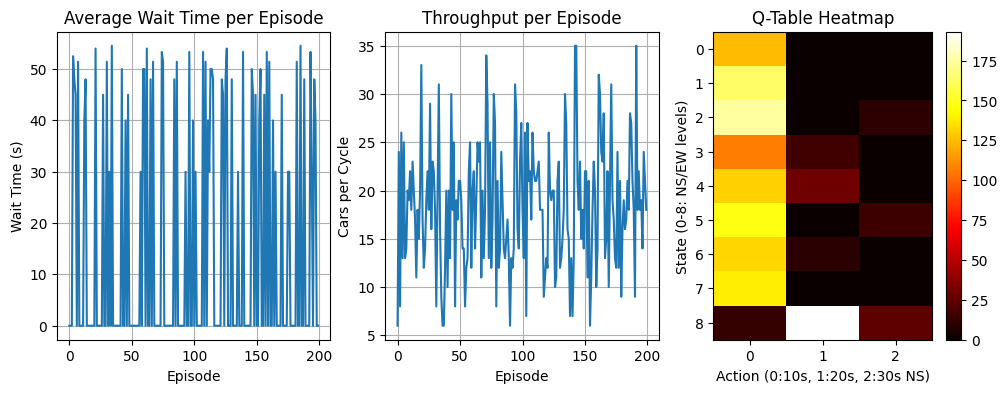

In [3]:
# Add after training loop
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(wait_times)
plt.title('Average Wait Time per Episode')
plt.xlabel('Episode')
plt.ylabel('Wait Time (s)')
plt.grid(True)
plt.subplot(1, 3, 2)
plt.plot(throughputs)
plt.title('Throughput per Episode')
plt.xlabel('Episode')
plt.ylabel('Cars per Cycle')
plt.grid(True)
plt.subplot(1, 3, 3)
plt.imshow(agent.Q, cmap='hot', aspect='auto')
plt.title('Q-Table Heatmap')
plt.xlabel('Action (0:10s, 1:20s, 2:30s NS)')
plt.ylabel('State (0-8: NS/EW levels)')
plt.colorbar()
plt.show()